In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

In [6]:
# loading the movie_titles.csv
movies=pd.read_csv('/movie_titles.csv', encoding = "ISO-8859-1", names=['id','year','title'])
# peek into the dataframe
movies.head()

,id,year,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In the following piece of code we're combining all the four text files containing the user ratings into one
massive rating.csv file.

In [7]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      17770 non-null  int64  
 1   year    17763 non-null  float64
 2   title   17770 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 416.6+ KB


In [19]:
# creating a new file if it doesn't exist already
if not os.path.isfile('/rating.csv'):
    
    # opening the newly created file on the 'write' mode
    rating=open('/rating.csv', mode='w')
    
    separated_data=['/combined_data_1.txt','/combined_data_2.txt',
                    '/combined_data_3.txt','/combined_data_4.txt']
    
    # iterating through the separate files containing the user ratings
    for file in separated_data:
        with open(file) as f:
            # processing each line of the currently open file
            for line in f: 
                line=line.strip()
                if line[-1]==':':
                    movie_id=line[:-1]
                else:
                    combining_rows=[x for x in line.split(',')]
                    combining_rows=[movie_id]+combining_rows
                    rating.write(','.join(combining_rows))
                    rating.write('\n')
        f.close()
    rating.close()

In [25]:
# loading the above new csv file into a dataframe
rating=pd.read_csv('/rating.csv', sep=',', 
                   names=['Movie_Id', 'Customer_Id','Rating','Date'])


In [26]:
# merging the movies dataframe with rating dataframe
df=pd.merge(movies, rating, left_on='id', right_on='Movie_Id', how='inner')


We're going to work with the following three variables only Movie_Id, Customer_Id and Rating.


In [27]:
df=df[['Movie_Id', 'Customer_Id', 'Rating']]

Exploratory Data Analysis

In [28]:
# checking the metadata
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 19615714 entries, 0 to 19615713
Data columns (total 3 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Movie_Id     int64  
 1   Customer_Id  int64  
 2   Rating       float64
dtypes: float64(1), int64(2)
memory usage: 598.6 MB


In [29]:
print(f'There are {df.Movie_Id.unique().shape[0]} unique movies in the dataframe')

There are 3694 unique movies in the dataframe


In [30]:
print(f'There are {df.Customer_Id.unique().shape[0]} customers in the dataframe')

There are 471583 customers in the dataframe


In [31]:
print(f"The minimum Customer_Id and the maximum Customer_Id in the df are {df.Customer_Id.min()} and {df.Customer_Id.max()} respectively and we \nknow that there are only {df.Customer_Id.unique().shape[0]} unique customers in the df which will lead to confusion. Hence we're going to map them as continuous integers")

The minimum Customer_Id and the maximum Customer_Id in the df are 6 and 2649429 respectively and we 
know that there are only 471583 unique customers in the df which will lead to confusion. Hence we're going to map them as continuous integers


In [32]:
# creating a dict map to map old Customer_Id to new and continuous Customer_Id
mapping={old:new for old,new in 
         list(zip(sorted(df.Customer_Id.unique()),
                  range(df.Customer_Id.unique().shape[0])))}

In [33]:
# applying the above mapping
df['Customer_Id']=df['Customer_Id'].map(mapping)

In [34]:
# checking if the new Customer_Id is continuous
print(df.Customer_Id.unique().shape[0])
print(df.Customer_Id.min())
print(df.Customer_Id.max())


471583
0
471582


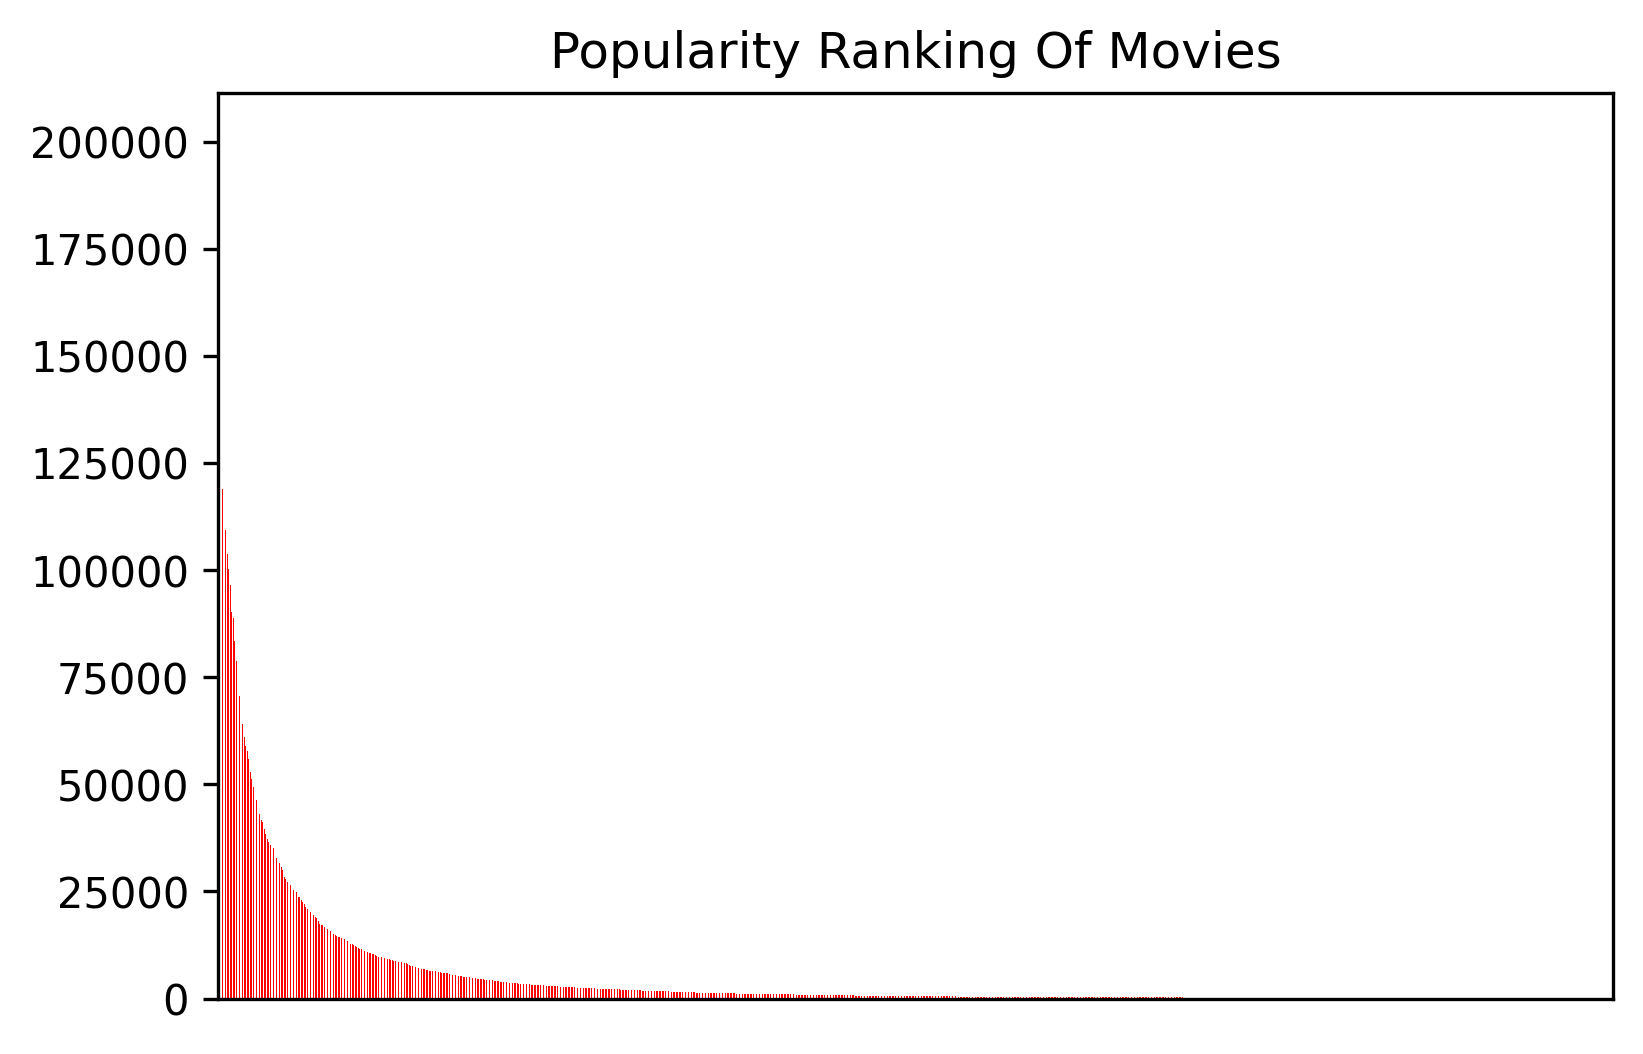

In [35]:
plt.figure(dpi=300)
plt.title('Popularity Ranking Of Movies')
df.Movie_Id.value_counts()[:6000].plot(kind='bar', color='red')
plt.xticks(ticks=[]);


The above plot shows the long tail distribution of the movies. The first few 100 movies or so have ratings steeply dropping from 230000 to 50000 and the rest of the movies have very low number of ratings. (Note that we've considered only the 6000 most popular movies).

Checking the distribution of ratings of the movies

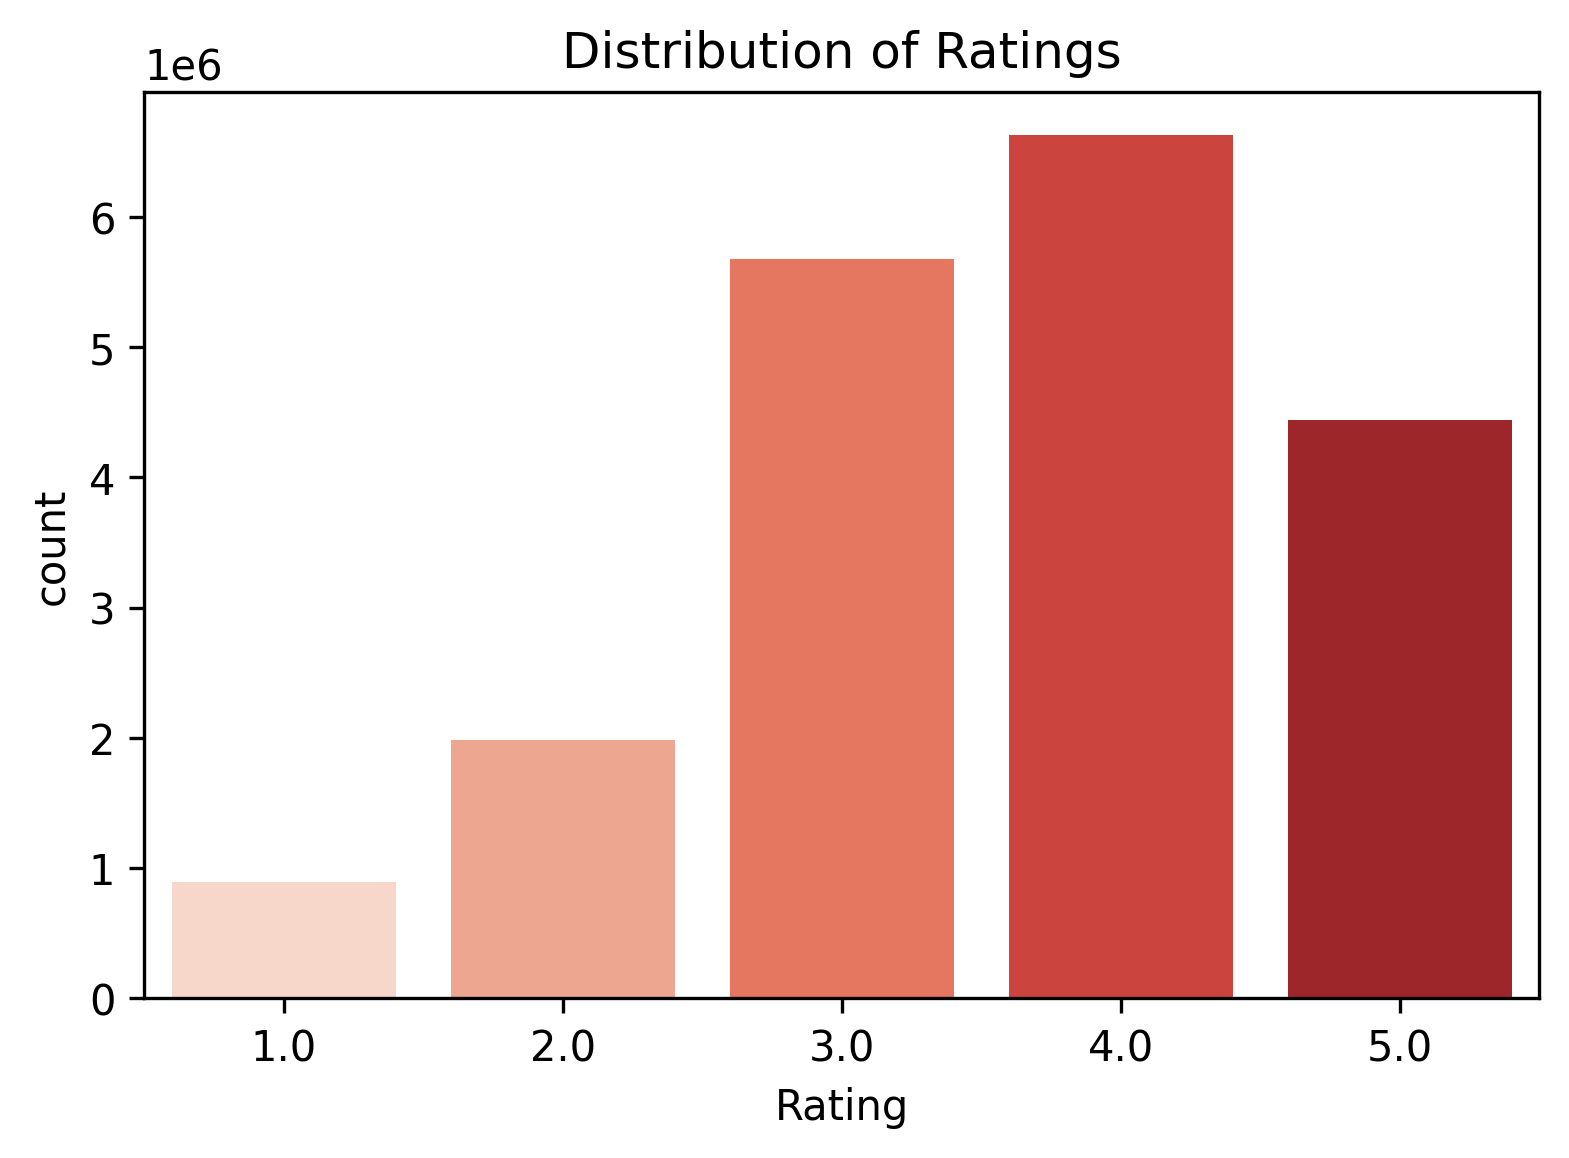

In [36]:
plt.figure(dpi=300)
plt.title('Distribution of Ratings')
sns.countplot(df.Rating, palette='Reds');

As we can clearly see that 4 stars and 3 stars are the most and the second most frequent ratings given by users.

In [37]:
# there are no NaNs in any of the columns
df.isna().sum()

Movie_Id       0
Customer_Id    0
Rating         3
dtype: int64

In [38]:
# there are no duplicated ratings
df.duplicated(['Movie_Id','Customer_Id']).sum()

0

List of top 20 best movies as per the average user rating.

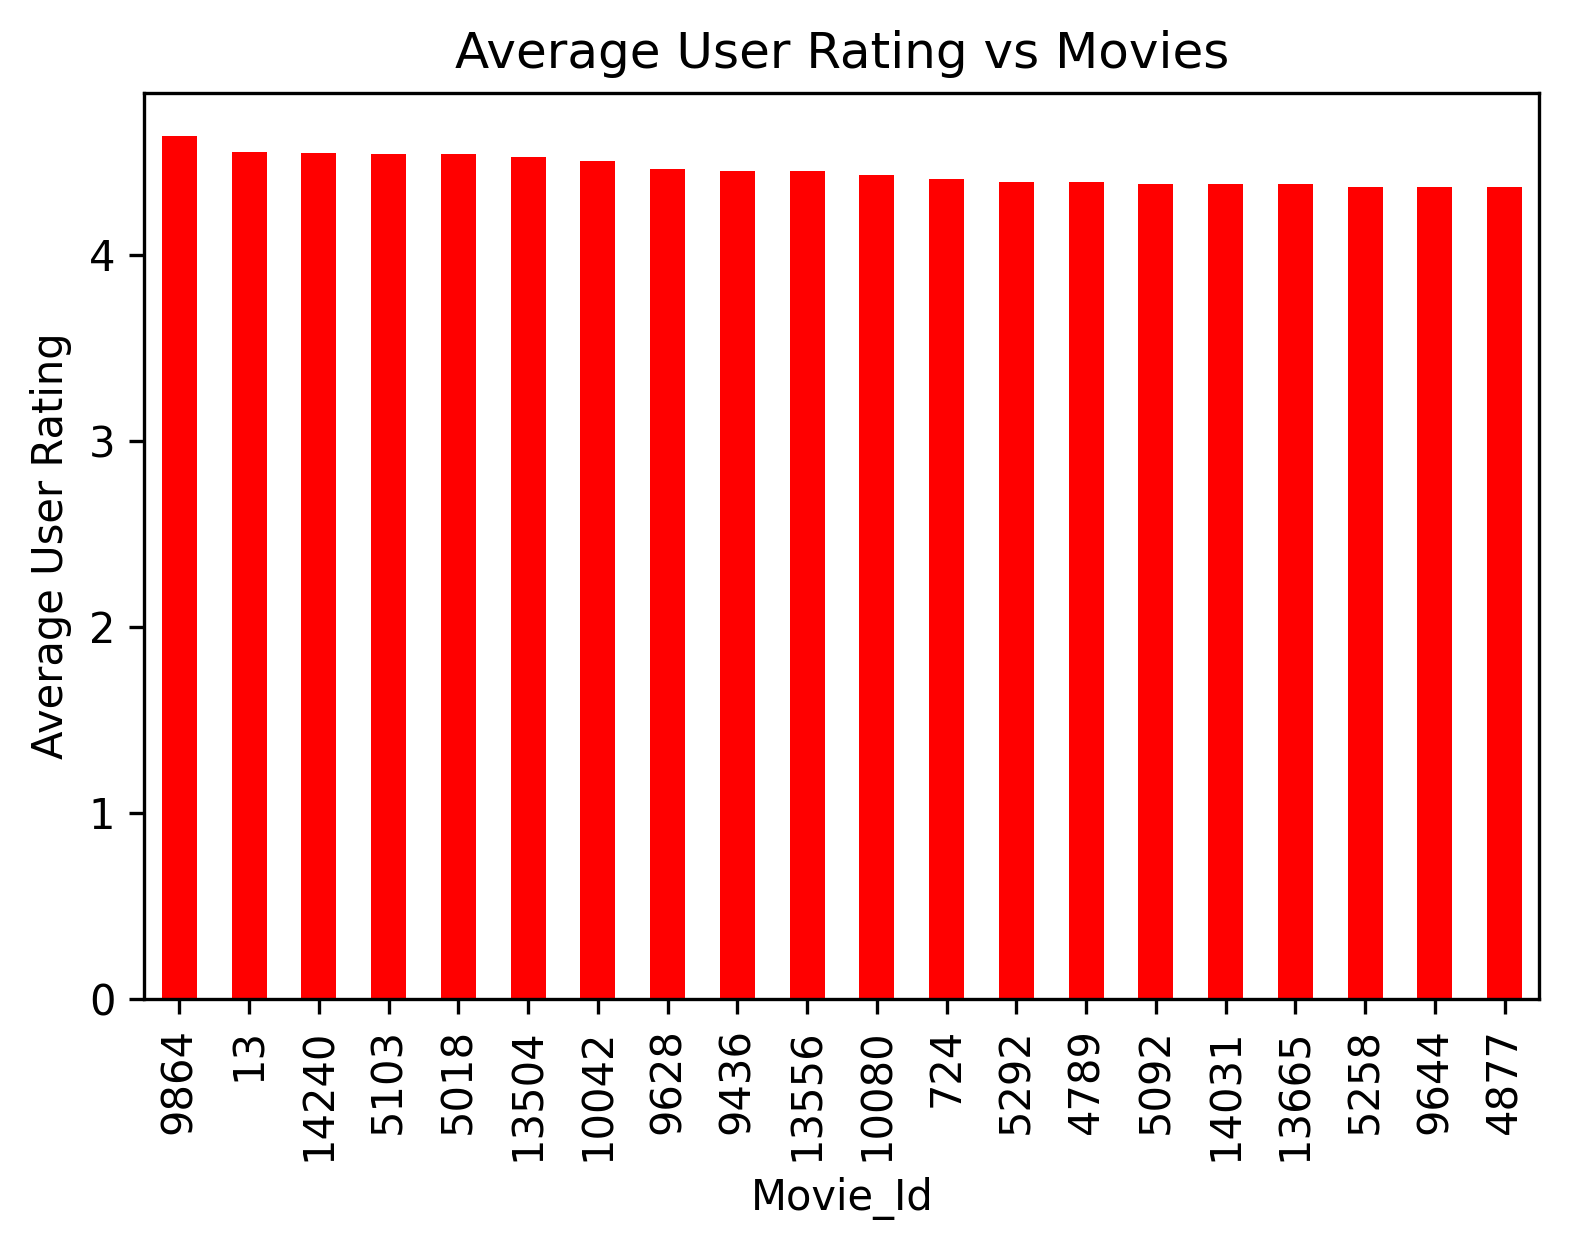

In [39]:
# average user rating of top 20 movies
plt.figure(dpi=300)
plt.title('Average User Rating vs Movies')
plt.ylabel('Average User Rating')
(df.groupby(by='Movie_Id')['Rating']
 .mean().sort_values(ascending=False)[:20]).plot(kind='bar', color='red');

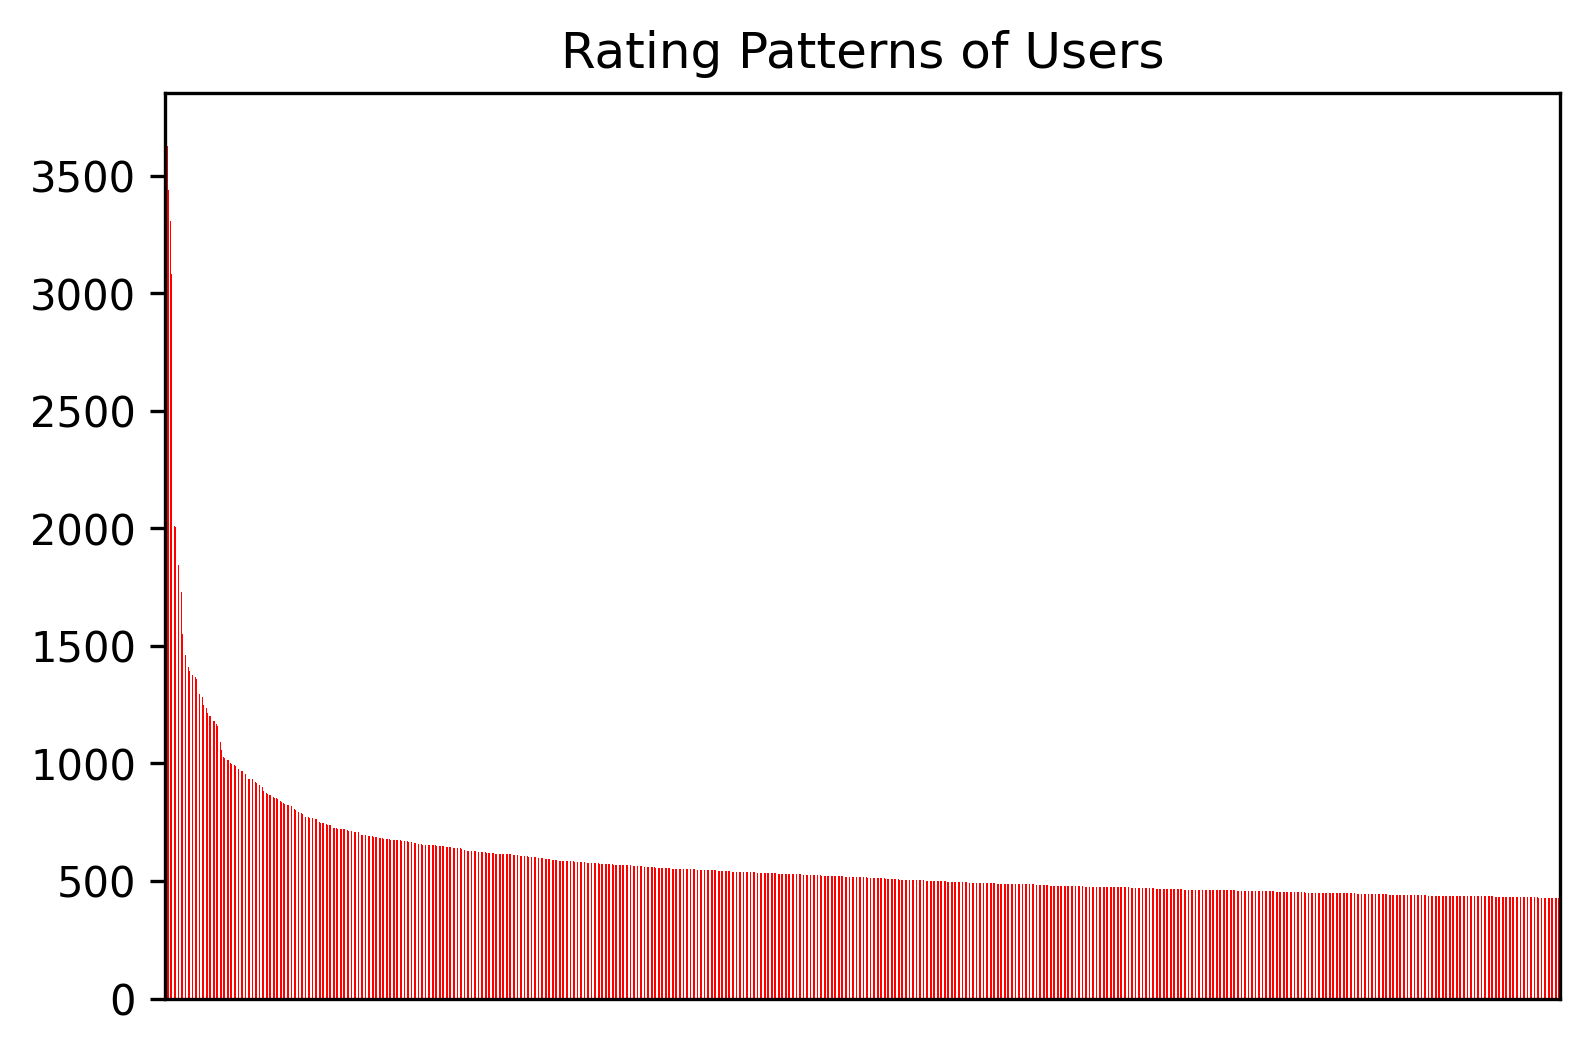

In [40]:
plt.figure(dpi=300)
plt.title('Rating Patterns of Users')
df.Customer_Id.value_counts()[:1000].plot(kind='bar', color='red')
plt.xticks(ticks=[]);

The above plot displays the rating patterns of the top 1000 frequent users and their rating behavior ranges from rating almost all movies to rating only handful of movies

In [41]:
# statistical description of ratings
df.Rating.describe()

count    1.961571e+07
mean     3.599236e+00
std      1.080596e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

Utility Matrix
Here we're going to produce the utility matrix by pivoting the dataframe df with Movie_Id as rows, Customer_Id as columns and the Rating as the cell values. Also we're going to use item-item cosine similarity based collaborative filtering technique to build our recommendation system.

Let's centre the rating vectors of every movie by subtracting it by average rating of the movie. We're doing this in order to make better sense of the cosine similarity.

In [42]:
# finding the average rating for each movie
mean_rating=df.groupby(by='Movie_Id')[['Rating']].mean()
mean_rating.head()

,Rating
Movie_Id,
1,3.749543
2,3.558621
3,3.641153
4,2.739437
5,3.919298


In [43]:
# merging the above df with the original df
tmp=pd.merge(df, mean_rating, left_on='Movie_Id', 
             right_index=True, how='inner')
tmp.head()

,Movie_Id,Customer_Id,Rating_x,Rating_y
0,1,265227,3.0,3.749543
1,1,146828,5.0,3.749543
2,1,157970,4.0,3.749543
3,1,5363,4.0,3.749543
4,1,147070,3.0,3.749543


In [44]:
# creating a df containing the movie-wise centred ratings
df=tmp[['Movie_Id','Customer_Id']]
df['Rating']=tmp['Rating_x']-tmp['Rating_y']
df.head()

,Movie_Id,Customer_Id,Rating
0,1,265227,-0.749543
1,1,146828,1.250457
2,1,157970,0.250457
3,1,5363,0.250457
4,1,147070,-0.749543


Since utility matrix is going to be a massive, we're going to use csr_matrix to represent it.

In [57]:
rows=df.Movie_Id.values
cols=df.Customer_Id.values
data=df.Rating.values

In [59]:
# unsupervised learning algo for recommendation system
from sklearn.neighbors import NearestNeighbors
# capturing the pair of movie index and user index who actually rated the movie

Recommender System Based On Collaborative Filtering Item-Item Cosine Similarity

Main function: The recommender function will first display top 5 highly rated movies by a given Customer_ID and then it'll display top 5 recommended movies for this user. Do not expect these recommended movies to be similar to these top 5 highly rated movies by the user. Top 5 highly rated movies are displayed only to give you a gist of this particular user's taste however this meagre list of top 5 cannot capture the his taste completely (Imagine this user has given 5 star rating for 40 movies and the top 5 highly rated movies by this user will be just the first instance of the top 5). But the top 5 recommendations take into all the movies that the user has rated.


In [53]:
def recommendations(user_id):
    # list of top 5 movies rated by the given user
    user_top_movies=utility[:,user_id].toarray().reshape(-1,)
    
    # finding the argmax for top 5 ratings
    user_top_movies=user_top_movies.argsort()[-5:][::-1]
    
    print(f'The list of top 5 rated movies by the Customer_Id {user_id} are')
    for film in movies.iloc[user_top_movies]['title'].values:
          print(film)
  
    # rating vectors of all the movies rated by this user
    # in otherwords utility submatrix
    sub_utility=utility[mov_idx[user_idx==user_id]]
    
    # instantiating KNN model with default 5 neigbors
    knn=NearestNeighbors(metric='cosine', n_jobs=-1, algorithm='brute')
    
    # training the above algorithm on the utility submatrix 
    knn.fit(sub_utility)
    
    # collecting list of movies not watched by this user
    unwatched =list(set(range(1,17771)).difference(set(mov_idx[user_idx==user_id])))
    
    unwatched_rating=[-10]*17771
    # for every unwatched film by this user
    for newfilm in unwatched:
        
        # we're finding the rating vector of the movie
        rate_vector=utility[newfilm].toarray()
        
        # extracting the cosine distances and movie_id
        distance,movieid=knn.kneighbors(rate_vector, 5, return_distance=True)
        
        # reshape the distance and the ids
        distance,movieid=distance.reshape(-1,),movieid.reshape(-1,)
        
        # converting cosine distance to cosine similarity
        similarity=1-distance
        
        # ratings of the aforementioned 5 most similar movies by this user
        rates=utility[:,user_id][movieid].toarray().reshape(-1,)
        
        # finding the weighted mean of the 5 highly rated movies
        predicted_rating=np.dot(similarity,rates)/np.abs(similarity).sum()
        
        # assigning the predicted_rating at the respective index 
        # corresponding to the movie index
        unwatched_rating[newfilm]=predicted_rating
    
    # converting it to numpy array
    unwatched_rating=np.array(unwatched_rating)
    
    # finding the argmax for top 5 ratings
    top_recommends=unwatched_rating.argsort()[-5:][::-1]
    
    print(f'\nThe list of top 5 recommended movies for the Customer_Id {user_id} are')
    for recommend in movies.iloc[top_recommends]['title'].values:
          print(recommend)
